In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms

from PIL import Image
from pylab import rcParams
from typing import cast, Any, Union, Dict, List
import time
import random
import copy 
 
import matplotlib.pyplot as plt

import os
import shutil
from collections import OrderedDict

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
# from google.colab import files
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Loading data

**Let's see what the data in the pandas table looks like**

In [3]:
## Data Mnist Image Folder
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((50,50)),
    transforms.RandomInvert(p=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
    ])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((50,50)),
    transforms.RandomInvert(p=1),
    transforms.ToTensor()
    ])

## import data from gdrive
train_set = datasets.ImageFolder('./fashion_mnist_datasets/train', transform=train_transform)
# trainloader = DataLoader(train_set, batch_size=100, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder('./fashion_mnist_datasets/test', transform=test_transform)
# validloader = DataLoader(valid_set, batch_size=100, shuffle=True)

train_set, val_set = torch.utils.data.random_split(train_set, [int(len(train_set) * 0.8), int(len(train_set) * 0.2)])

train_dataloader = torch.utils.data.DataLoader(train_set,
                                        batch_size = 100,
                                        shuffle = True)

val_dataloader = torch.utils.data.DataLoader(val_set,
                                        batch_size = 100)

loaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

In [4]:
print(train_set.dataset.class_to_idx)

{'Ankle Bot': 0, 'Bag': 1, 'Coat': 2, 'Dress': 3, 'Hat': 4, 'Pullover': 5, 'Sandal': 6, 'Shirt': 7, 'Sneaker': 8, 'T-shirt-top': 9, 'Trouser': 10}


In [5]:
#for metrics
dataset_sizes = { 'train': len(train_set), 'val': len(val_set)}
print(dataset_sizes)
#for normalization
# dataset_sizes_for_norm = {'train': len(train_set), 'val': len(val_set)}
# loaders_for_norm = {
#     'train': DataLoader(train_set, batch_size=100, shuffle = True, num_workers=4),
#     'val': DataLoader(val_set, batch_size=100, shuffle = True, num_workers=4)
# }

#show
# dataset_sizes, dataset_sizes_for_norm

{'train': 50640, 'val': 12660}


In [6]:
# for x in ['train', 'val']:
   
#   #number of pixels in the dataset = number of all pixels in one object * number of all objects in the dataset
#   num_pxl = dataset_sizes_for_norm[x]*28*28
    
#   #we go through the butches and sum up the pixels of the objects, 
#   #which then divide the sum by the number of all pixels to calculate the average
#   total_sum = 0
#   for batch in loaders_for_norm[x]: total_sum += batch[0].sum()
#   mean = total_sum / num_pxl

#     #we calculate the standard deviation using the formula that I indicated above
#   sum_sqrt = 0
#   for batch in loaders_for_norm[x]: sum_sqrt += ((batch[0] - mean).pow(2)).sum()
#   std = torch.sqrt(sum_sqrt / num_pxl)

#   # print(f'{x} - mean: {mean}, std: {std}')

**Let's see what the images look like**

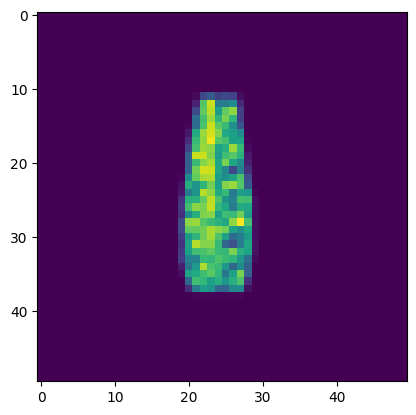

In [7]:
i = np.random.randint(50)
x, y = next(iter(train_dataloader))
plt.imshow(x[i].view(50,50))

# Model

In [8]:
class VGG(nn.Module):
  def __init__(self, features:nn.Module, num_classes:int=1000, init_weights:bool=True):
      super(VGG, self).__init__()
      self.features = features #features = Feature extraction
      self.avgpool = nn.AdaptiveAvgPool2d((1,1))
      self.classifier = nn.Sequential(
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Linear(256, 128),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Linear(64, num_classes)
          )

      if init_weights:
        self.initialize_weights()
  
  def forward(self, x):
    x = self.features(x) #features = Feature extraction
    x = self.avgpool(x)
    # print(x.shape)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

  def initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0) 
      if isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0) 

cfgs: Dict[str, List[Union[int, str]]] = {
    'A': [64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'firstPadding':2
}

def make_layers(cfg:List[Union[int,str]], batch_norm:bool=False) -> nn.Sequential:
  layers:List[nn.Module] = []
  in_channels = 1
  in_padding = 5
  i = 0
  for v in cfg:
    if v == 'M':
      layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
    else:
      v = cast(int, v)
      in_padding = 1
      if i == 5:
        in_padding = 2
      conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=in_padding)
      if batch_norm:
        layers += [conv2d, nn.BatchNorm2d(v), nn.PReLU(num_parameters=1)]
      else:
        layers += [conv2d, nn.PReLU(num_parameters=1)] #nn.PReLU(num_parameters=1) nn.ReLU(inplace=True)
      in_channels = v
    i += 1
  return nn.Sequential(*layers)


def selfDefineVgg(arch, cfg, batch_norm,  num_classes:int, **kwargs: Any) -> VGG:
    model = VGG(make_layers(arch[cfg], batch_norm=batch_norm), num_classes, **kwargs)
    return model
model = selfDefineVgg(cfgs, 'A', True, 11)
model = model.to(device)

In [9]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): PReLU(num_parameters=1)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): PReLU(num_parameters=1)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): PReLU(num_parameters=1)
  

**Loss function, Optimizer, Scheduler**

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9,0.999), eps=1e-9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1, verbose=False)###Best accuracy 0.9349, tensor(0.9385)

# Train

In [11]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

def train(model, criterion, optimizer, scheduler, epochs):
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(float(epoch_loss))
      accuracies[phase].append(float(epoch_acc))
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
            
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step()  
  time_elapsed = time.time() - since
  print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60)) 
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model   

**Launching training**

In [12]:
epochs = 10
torch.cuda.empty_cache()

model = train(model, criterion, optimizer, scheduler, epochs)

Epoch: 1/10
train - loss:1.6285269405887026, accuracy0.3454383886255924
val - loss:1.229637362192404, accuracy0.4911532385466034
Time: 3.0m 4.737192392349243s
Epoch: 2/10
train - loss:1.1106214795208655, accuracy0.5527646129541863
val - loss:1.0753306216349912, accuracy0.572432859399684
Time: 5.0m 43.49246406555176s
Epoch: 3/10
train - loss:0.9702818711269147, accuracy0.6100908372827804
val - loss:0.984958150469673, accuracy0.5897314375987361
Time: 8.0m 22.95179009437561s
Epoch: 4/10
train - loss:0.8805554823429098, accuracy0.6434241706161137
val - loss:0.919695593075353, accuracy0.619431279620853
Time: 11.0m 2.271793842315674s
Epoch: 5/10
train - loss:0.7749795781163055, accuracy0.6821879936808846
val - loss:0.7208415978892719, accuracy0.7059241706161137
Time: 13.0m 41.57698845863342s
Epoch: 6/10
train - loss:0.7423438173711394, accuracy0.6968799368088467
val - loss:0.6915018322155185, accuracy0.7188783570300158
Time: 16.0m 20.837994813919067s
Epoch: 7/10
train - loss:0.72631825792704

**Visualization**

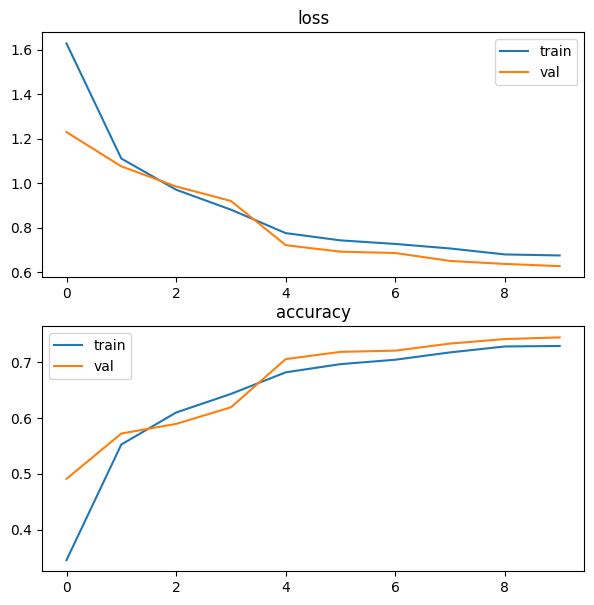

In [13]:
rcParams['figure.figsize'] = 7, 7

fig, axs = plt.subplots(2)

axs[0].plot([x for x in range(epochs)], losses['train'], label ='train')
axs[0].plot([x for x in range(epochs)], losses['val'], label='val')
axs[0].set_title('loss')
axs[0].legend()

axs[1].plot([x for x in range(epochs)], accuracies['train'], label ='train')
axs[1].plot([x for x in range(epochs)], accuracies['val'], label='val')
axs[1].set_title('accuracy')
axs[1].legend()

# Test

**Uploading the data**

In [14]:
loadersq=  DataLoader(test_set, batch_size=100, shuffle = True, num_workers=4)

**Creating a dictionary with the size of the test dataset.**

In [15]:
dataset_sizesq = len(test_set)
dataset_sizesq

10300

**Similarly, we calculate the average and standard deviation for test**

In [16]:
# num_px = dataset_sizesq*28*28


# total_sum = 0
# for batch in loadersq: total_sum += batch[0].sum()
# mean = total_sum / num_px

# sum_of_squared_error = 0
# for batch in loadersq: sum_of_squared_error += ((batch[0] - mean).pow(2)).sum()
# std = torch.sqrt(sum_of_squared_error / num_px)

# mean, std

**Predictions**

In [17]:
corr = 0

with torch.no_grad():
    for data in loadersq:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        y_pred = model(images)
        _, predicted = torch.max(y_pred, 1)
        corr += torch.sum(predicted == labels.data)

print(f"Test accuracy: {corr/dataset_sizesq}")

Test accuracy: 0.7828155755996704


In [18]:
def output_label(label):
    output_mapping = { # From New Dataset
                 0: "Ankle Bot",
                 1: "Bag",
                 2: "Coat",
                 3: "Dress",
                 4: "Hat",
                 5: "Pullover",
                 6: "Sandal",
                 7: "Shirt",
                 8: "Sneaker",
                 9: "T-shirt-top",
                 10: "Trouser"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

class_correct = [0. for _ in range(11)]
total_correct = [0. for _ in range(11)]

with torch.no_grad():
    for images, labels in loadersq:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(11):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of Ankle Bot: 93.70%
Accuracy of Bag: 93.40%
Accuracy of Coat: 57.60%
Accuracy of Dress: 83.40%
Accuracy of Hat: 83.00%
Accuracy of Pullover: 76.20%
Accuracy of Sandal: 91.00%
Accuracy of Shirt: 11.00%
Accuracy of Sneaker: 93.30%
Accuracy of T-shirt-top: 86.20%
Accuracy of Trouser: 95.60%


## Predict with Jury Test

In [19]:
import torchvision.transforms.functional as F
# Show Function for image tensor
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

from PIL import ImageStat

def is_grayscale(path):
    im = Image.open(path).convert("RGB")
    stat = ImageStat.Stat(im)
    if sum(stat.sum)/3 == stat.sum[0]: #check the avg with any element value
        return True #if grayscale
    else:
        return False #else its colour

In [20]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# from google.colab.patches import cv2_imshow

def pre_image(image_path,model):
   transform_norm_grayscale = transforms.Compose([
       transforms.Resize((50,50)),
       transforms.ToTensor()
       ])
   transform_norm_rgb = transforms.Compose([
       transforms.Grayscale(),
       transforms.Resize((50,50)),
       transforms.RandomInvert(p=1),
       transforms.ToTensor()
       ])

   # Read Image
   img = Image.open(image_path).convert('L')
   #  display(img)

   # Is Image Grayscale?
   if (is_grayscale(image_path)):
       print("Grayscale")
       img_normalized = transform_norm_grayscale(img).float()
       show(img_normalized)
       img_normalized = img_normalized.unsqueeze_(0)
       img_normalized = img_normalized.to(device)
   else:
       print("RGB")
       img_normalized = transform_norm_rgb(img).float()
       show(img_normalized)
       img_normalized = img_normalized.unsqueeze_(0)
       img_normalized = img_normalized.to(device)

   print("Shape Image:",img_normalized.shape)
   with torch.no_grad(): # Predict Image
      model.eval()
      output =model(img_normalized)
     # print(output)
      index = output.data.cpu().numpy().argmax()
      classes = ["Ankle Bot", "Bag", "Coat", "Dress", "Hat","Pullover", "Sandal", "Shirt", "Sneaker", "T-shirt/Top", "Trouser"]
      class_name = classes[index]
      return class_name

RGB
Shape Image: torch.Size([1, 1, 50, 50])
Hat


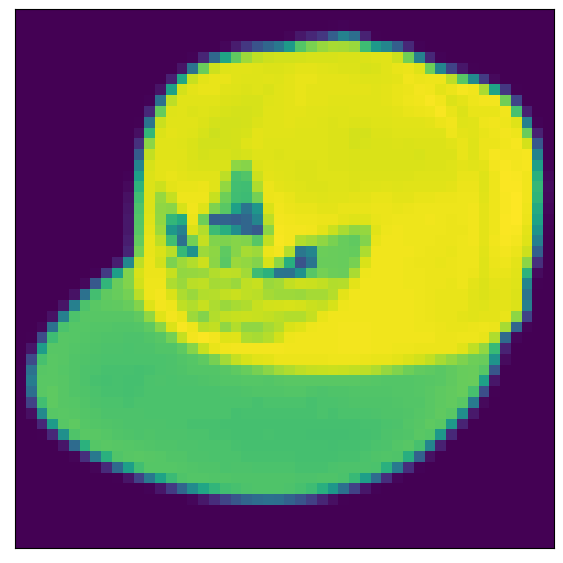

In [21]:
# Test from local
test_file_path = "Jury_test/hat_3.jpg"
predict_class = pre_image(test_file_path, model)
print(predict_class)

## Save Model

In [22]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%Y-%m-%d_%H-%M-%S")

DIR_NAME = "./ModelsSave"
if os.path.exists(DIR_NAME) == False:
    os.mkdir(DIR_NAME)

# Save model
torch.save(
    model.state_dict(),
    DIR_NAME+'/model={}-{:.4f}.pth'.format(current_time, max(accuracies['val']))
)